In [18]:
# Binary Classification 
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from keras.optimizers import RMSprop,Adam
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from visual_callbacks import AccLossPlotter,  ConfusionMatrixPlotter
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NeighbourhoodCleaningRule, OneSidedSelection

In [19]:
#plot confisuon matrix metodu
def plot_confusion_matrix(cm, names,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
# load dataset
dataframe = pd.read_csv("KidneyStoneDataset.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:5120]
Y = dataset[:,5120]
#verileri normalize etmesem de sonuç değişmiyor
normalized_X = preprocessing.normalize(X) 

In [21]:
print(normalized_X)
print(Y)

[[7.13e-04 1.07e-03 1.19e-03 ... 1.45e-02 1.60e-02 1.27e-02]
 [7.80e-04 7.80e-04 7.80e-04 ... 1.34e-03 5.57e-04 2.23e-04]
 [4.57e-04 3.48e-03 9.69e-03 ... 9.15e-05 9.15e-05 0.00e+00]
 ...
 [1.10e-02 1.14e-02 1.61e-02 ... 6.32e-03 6.65e-03 8.60e-03]
 [3.76e-03 4.77e-03 5.21e-03 ... 7.67e-03 6.37e-03 5.35e-03]
 [1.16e-02 4.15e-03 2.08e-03 ... 1.77e-02 1.78e-02 1.80e-02]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [22]:
len(X)

221

Verisetinde 221 adet veri bulunmaktadır. Bunlardan 39 tanesi sağlıklı (0 etiketi), 182 tanesi ise hasta (1 etiketi) olarak belirlenmiştir.

In [23]:
X = np.array(normalized_X) 
y = np.array(Y)

In [24]:
#undersampling-oversampling işlemleri
over = SMOTE(sampling_strategy=0.3)
#under = RandomUnderSampler(sampling_strategy=0.6)
#over=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [25]:
#gridsearch for decision tree
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    #for decision tree
    #param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)} 
    
    #for RANDOM FOREST
    #param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 
    #              'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
    
    
    #FOR SVC
    #param_grid = {'C': [0.1, 1, 10, 100, 1000],  
    #          'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
     #        'kernel': ['rbf']}  
    
    #FOR MLPClassifier
    #param_grid={'solver': ['sgd','adam','lbfgs'],'max_iter': [300,500,700,1000],
    #'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive']}
 
    #knn
    #param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
     #                                    13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
      #                                   23, 24, 25, 26, 27, 28, 29, 30]}
   #bayes
    #param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
     #    }
   # decision tree model
   # dtree_model=DecisionTreeClassifier()
    #dtree_model=RandomForestClassifier()
    #dtree_model=svm.SVC()
    #dtree_model=MLPClassifier()
    #dtree_model=KNeighborsClassifier()
    #dtree_model=BernoulliNB()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [26]:
#print(dtree_grid_search(X,y,5))

In [28]:
#kullanılan algoritmalar ve cv yöntemi

modelArray = []
modelLabelArray = ['DecisionTreeClassifier','RandomForestClassifier','SVC','MLPClassifier','KNeighborsClassifier','BernoulliNB']

modelArray.append(DecisionTreeClassifier(criterion='gini',max_depth=3))
modelArray.append(RandomForestClassifier(criterion= 'entropy', max_depth= 4, max_features= 'log2', n_estimators= 200))
modelArray.append(svm.SVC(C=0.1, gamma=1, kernel='rbf'))
modelArray.append(MLPClassifier(random_state=1, max_iter=300))
modelArray.append(KNeighborsClassifier(n_neighbors= 16))
modelArray.append(BernoulliNB(alpha= 10.0))

stepsArray = []
pipelineArray = []
for i in range(len(modelArray)):
    stepsArray.append([ ('o',over),('m', modelArray[i])])
    
for j in range(len(stepsArray)):
    pipelineArray.append(Pipeline(steps=stepsArray[j]))
    

# evaluate pipeline
n_splits=5
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
cv = StratifiedKFold(n_splits=n_splits,random_state=None,shuffle=True)

train test split: %80 train, %20 test

In [29]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
# summarize
print("Train size: %d" % len(trainX))
print("Test size: %d" % len(testX))

Train size: 176
Test size: 45


In [30]:
accArray=[]
recallArray=[]
scoreArray=[]

for i in range(len(pipelineArray)):
    #Cross validation ile Precision, recall ve f1 score değerlerinin hesaplanması
    acc = cross_val_score(pipelineArray[i],trainX, trainy, scoring='precision', cv=cv, n_jobs=-1)
    acc = mean(acc)
    accArray.append(acc)
    print(modelLabelArray[i]+' Precision: %.3f' % acc)
    recall = cross_val_score(pipelineArray[i], trainX, trainy, scoring='recall', cv=cv, n_jobs=-1)
    recall = mean(recall)
    recallArray.append(recall)
    print(modelLabelArray[i]+' Recall: %.3f' % acc)
    scores = cross_val_score(pipelineArray[i],trainX, trainy, scoring='f1', cv=cv, n_jobs=-1)
    score = mean(scores)
    scoreArray.append(score)
    print(modelLabelArray[i]+' F1 Score: %.3f' % score)
    


DecisionTreeClassifier Precision: 0.853
DecisionTreeClassifier Recall: 0.853
DecisionTreeClassifier F1 Score: 0.861
RandomForestClassifier Precision: 0.855
RandomForestClassifier Recall: 0.855
RandomForestClassifier F1 Score: 0.917
SVC Precision: 0.858
SVC Recall: 0.858
SVC F1 Score: 0.924
MLPClassifier Precision: 0.857
MLPClassifier Recall: 0.857
MLPClassifier F1 Score: 0.899
KNeighborsClassifier Precision: 0.856
KNeighborsClassifier Recall: 0.856
KNeighborsClassifier F1 Score: 0.875
BernoulliNB Precision: 0.858
BernoulliNB Recall: 0.858
BernoulliNB F1 Score: 0.924


DecisionTreeClassifier
Precision: 0.750
Recall: 0.677
F1 Score: 0.712
Confusion matrix
[[ 7  7]
 [10 21]]
RandomForestClassifier
Precision: 0.659
Recall: 0.871
F1 Score: 0.750
Confusion matrix
[[ 0 14]
 [ 4 27]]
SVC
Precision: 0.689
Recall: 1.000
F1 Score: 0.816
Confusion matrix
[[ 0 14]
 [ 0 31]]


D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer

MLPClassifier
Precision: 0.735
Recall: 0.806
F1 Score: 0.769
Confusion matrix
[[ 5  9]
 [ 6 25]]
KNeighborsClassifier
Precision: 0.676
Recall: 0.806
F1 Score: 0.735
Confusion matrix
[[ 2 12]
 [ 6 25]]
BernoulliNB
Precision: 0.689
Recall: 1.000
F1 Score: 0.816
Confusion matrix
[[ 0 14]
 [ 0 31]]


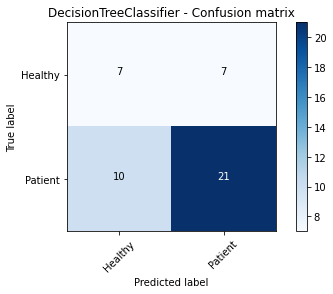

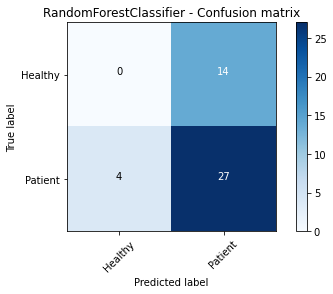

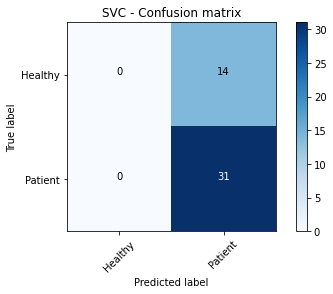

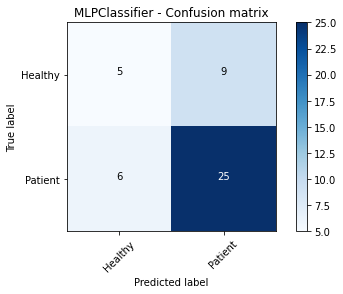

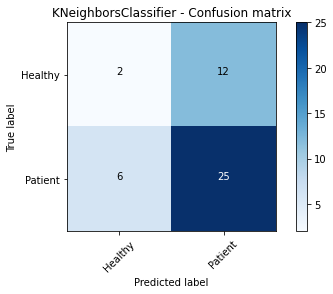

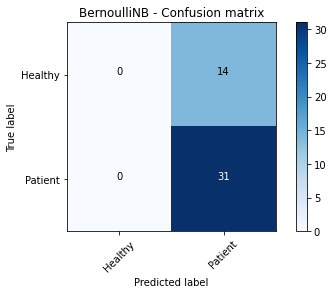

In [34]:
over = SMOTE(sampling_strategy=0.6)
stepsArray = []
pipelineArray = []
for i in range(len(modelArray)):
    stepsArray.append([ ('o',over),('m', modelArray[i])])
    
for j in range(len(stepsArray)):
    pipelineArray.append(Pipeline(steps=stepsArray[j]))

for i in range(len(scoreArray)):
    #oversampling ve Decision Tree yöntemi sonucu oluşan cross_val_predict confisuon matrix
    y_pred = cross_val_predict(pipelineArray[i], testX, testy, cv=cv)
    precision = precision_score(testy, y_pred)
    print(modelLabelArray[i])
    print('Precision: %.3f' % precision)
    recall = recall_score(testy, y_pred)
    print('Recall: %.3f' % recall)
    f1=f1_score(testy,y_pred)
    print('F1 Score: %.3f' % f1)


    cm = confusion_matrix(testy, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix')
    print(cm)
    plt.figure()
    class_names = ['Healthy', 'Patient']
    plot_confusion_matrix(cm, class_names, title=modelLabelArray[i] + ' - Confusion matrix')


